## Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
import joblib

## Loading the training dataset

In [2]:
train = pd.read_csv('train.csv')
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


## Understanding and examining the structure and organization of the dataset

In [3]:
train.shape

(550068, 12)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [5]:
train.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [6]:
train[train.duplicated()]

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase


## Data Cleaning & Preprocessing

In [7]:
train['Product_Category_2'].fillna(train['Product_Category_2'].mean(),inplace=True)
train['Product_Category_3'].fillna(train['Product_Category_3'].mean(),inplace=True)

In [8]:
train.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64

In [9]:
train['Gender'].value_counts()

M    414259
F    135809
Name: Gender, dtype: int64

In [10]:
train['Gender'].replace(['M','F'],[1,0],inplace=True)
train['Gender'] = train['Gender'].astype(int)

## Exploratory Data Analysis

<AxesSubplot:>

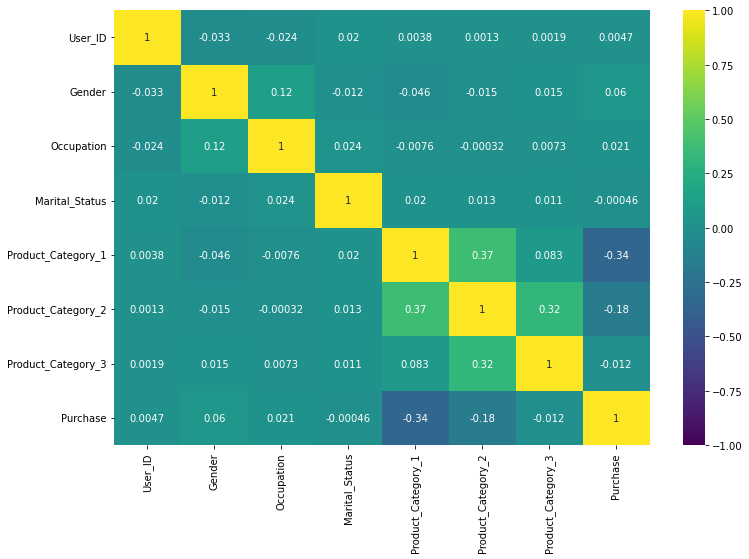

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(),annot=True,cmap='viridis',vmin=-1,vmax=1)

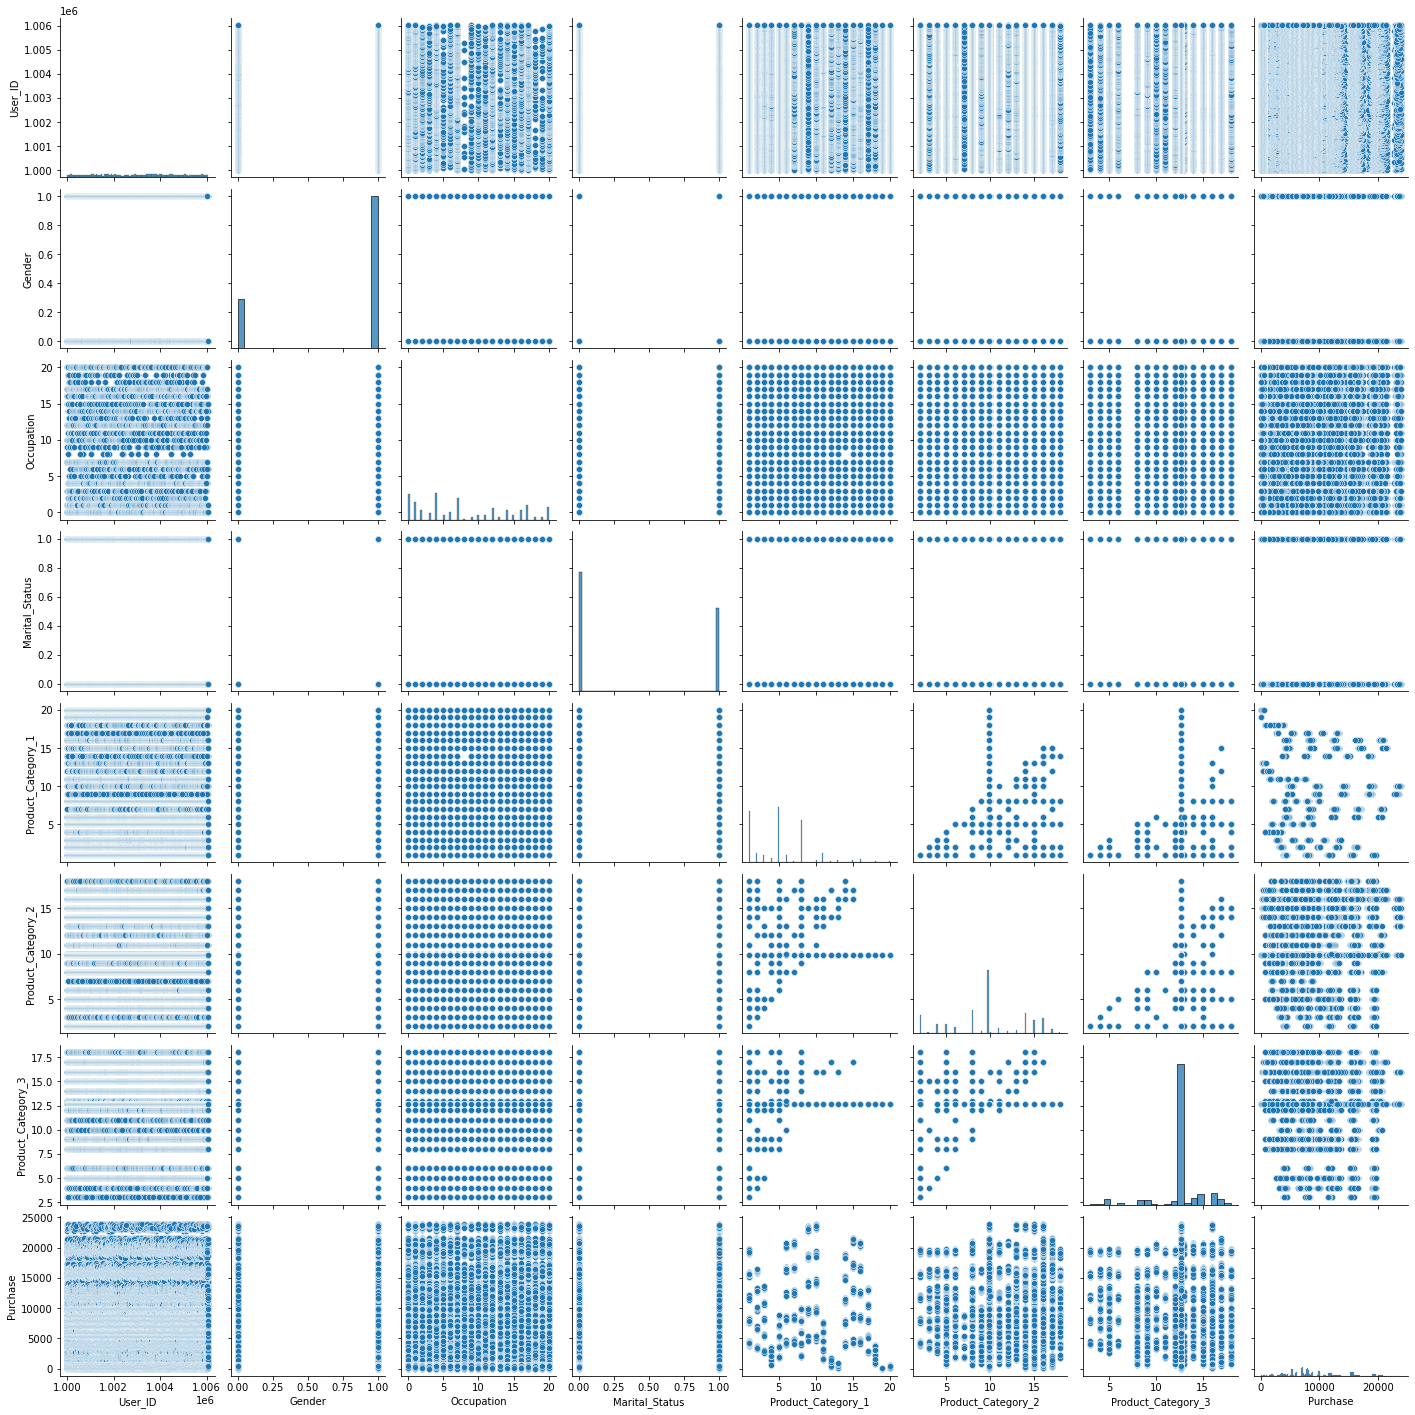

In [12]:
sns.pairplot(train)

<AxesSubplot:xlabel='Age', ylabel='count'>

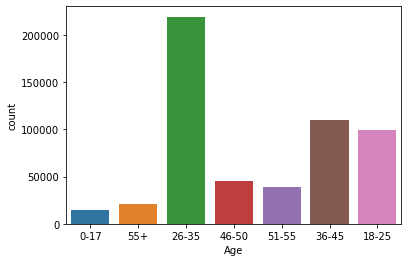

In [13]:
sns.countplot(train['Age'])

([<matplotlib.patches.Wedge at 0x1e602a6ce80>,
 [Text(0.29746897723579774, 1.1625455722604119, 'B'),
  Text(-0.9774040218269879, -0.5046596656326213, 'C'),
  Text(0.7311976184733743, -0.8217968378734892, 'A')],
 [Text(0.17352357005421531, 0.6781515838185737, '42.0%'),
  Text(-0.5331294664510843, -0.27526890852688435, '31.1%'),
  Text(0.3988350646218405, -0.4482528206582668, '26.9%')])

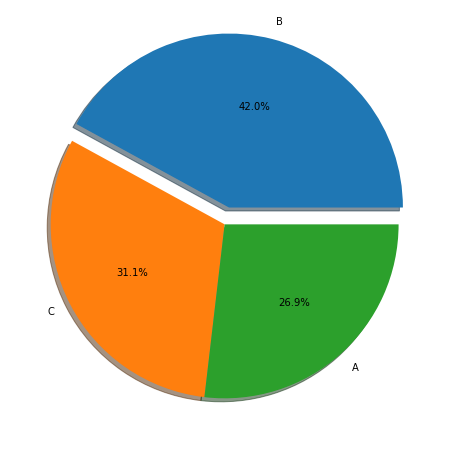

In [14]:
plt.figure(figsize=(12,8))
values = train['City_Category'].value_counts().values
labels = train['City_Category'].value_counts().keys()
explode = (0.1,0,0)
plt.pie(values,labels=labels,explode=explode,shadow=True,autopct='%1.1f%%')

## Categorical Encoding

In [15]:
train['Stay_In_Current_City_Years'].replace('4+','4',inplace=True)

In [16]:
train['Stay_In_Current_City_Years'] = train['Stay_In_Current_City_Years'].astype(int)

In [17]:
city_categories = {'A': 1, 'B': 2, 'C': 3}
train['City_Category'] = train['City_Category'].map(city_categories)
train['City_Category'].head()

0    1
1    1
2    1
3    1
4    3
Name: City_Category, dtype: int64

In [18]:
train['City_Category'] = train['City_Category'].astype(int)

In [19]:
le = LabelEncoder()
train['User_ID'] = le.fit_transform(train['User_ID'])
train['Product_ID'] = le.fit_transform(train['Product_ID'])
train['User_ID'] = train['User_ID'].astype(int)
train['Product_ID'] = train['Product_ID'].astype(int)

In [20]:
train['Age'] = le.fit_transform(train['Age'])
train['Age'] = train['Age'].astype(int)
train['Age'].dtypes

dtype('int32')

## Loading the test dataset

In [21]:
test = pd.read_csv('test.csv')
test_c = test.copy()
test.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,NaN
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0


## Cleaning and transforming the test dataset into the desired form

In [22]:
test['User_ID'] = le.fit_transform(test['User_ID'])
test['User_ID'] = test['User_ID'].astype(int)
test['Product_ID'] = le.fit_transform(test['Product_ID'])
test['Product_ID'] = test['Product_ID'].astype(int)

In [23]:
test['Gender'].replace(['M','F'],[1,0],inplace=True)
test['Gender'] = test['Gender'].astype(int)
test['Age'] = le.fit_transform(test['Age'])
test['Age'] = test['Age'].astype(int)
test['City_Category'] = test['City_Category'].map(city_categories)
test['City_Category'] = test['City_Category'].astype(int)
test['Stay_In_Current_City_Years'].replace('4+','4',inplace=True)
test['Stay_In_Current_City_Years'] = test['Stay_In_Current_City_Years'].astype(int)
test['Product_Category_2'].fillna(test['Product_Category_2'].mean(),inplace=True)
test['Product_Category_3'].fillna(test['Product_Category_3'].mean(),inplace=True)

## Performing feature scaling and normalization along with dividing the training dataset into training and testing sets..

In [24]:
X = train.drop('Purchase',axis=1)
y = train['Purchase']
scaler = StandardScaler()
features = X.columns
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X,columns=features)
X_train, X_test, y_train, y_test = train_test_split(scaled_X,y,test_size=0.2,random_state=1)

# Model Training & Evaluation

## Linear Regression

In [25]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [26]:
lr.score(X_test,y_test)

0.13733388804479885

## XG Boost Regressor

In [27]:
xgb = XGBRegressor(n_estimators=500,learning_rate=0.2,gamma=0,min_child_weight=12,subsample=0.6,colsample_bytree=1,max_depth=8)
xgb.fit(X_train.values,y_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=12,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [28]:
xgb.score(X_test.values,y_test.values)

0.7497422220045522

In [29]:
xgb_pred = xgb.predict(X_test.values)
print('RMSE:',np.sqrt(MSE(y_test,xgb_pred)))
print("R2 Score:",r2_score(y_test,xgb_pred))

RMSE: 2517.4848783807606
R2 Score: 0.7497422220045522


In [30]:
xgb = cross_val_score(xgb,X_train,y_train,cv=5)
print(xgb)
print('Mean Score:',np.mean(xgb))

[0.74175019 0.74536671 0.74324443 0.74455251 0.74497785]
Mean Score: 0.7439783375776712


## Random Forest Regressor

In [31]:
rfc = RandomForestRegressor(n_estimators=400)
rfc.fit(X_train,y_train)

RandomForestRegressor(n_estimators=400)

In [32]:
rfc.score(X_test,y_test)

0.7067128266952928

In [33]:
rfc_pred = rfc.predict(X_test)
print('RMSE:',np.sqrt(MSE(y_test,rfc_pred)))

RMSE: 2725.3332413119538


## Decision Tree Regressor

In [34]:
dtree = DecisionTreeRegressor()
dtree.fit(X_train,y_train)

DecisionTreeRegressor()

In [35]:
dtree.score(X_test,y_test)

0.4437845612186545

In [36]:
dtree_pred = dtree.predict(X_test)
print('RMSE:',np.sqrt(MSE(y_test,dtree_pred)))
print('R2 Score:',r2_score(y_test,dtree_pred))

RMSE: 3753.138559724891
R2 Score: 0.4437845612186545


## Establishing the final dataframe with the model predictions

In [37]:
df = pd.concat([pd.DataFrame(xgb_pred),test_c['User_ID'],test_c['Product_ID']],axis=1)
df.head()

,0,User_ID,Product_ID
0,7249.393555,1000004,P00128942
1,2613.526855,1000009,P00113442
2,5985.534668,1000010,P00288442
3,7909.326172,1000010,P00145342
4,14124.050781,1000011,P00053842


In [38]:
df.shape

(233599, 3)

In [39]:
df.to_csv('submission.csv')

## Saving the XGBoost model

In [40]:
joblib.dump(xgb,'model.pkl')

['model.pkl']

In [41]:
joblib.load('model.pkl')

array([0.74175019, 0.74536671, 0.74324443, 0.74455251, 0.74497785])